In [155]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt') 
nltk.download('stopwords')
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/leon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/leon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [156]:
files = ['Data/Customer_review_data/Apex AD2600 Progressive-scan DVD player.txt',
         'Data/Customer_review_data/Canon G3.txt',
         'Data/Customer_review_data/Creative Labs Nomad Jukebox Zen Xtra 40GB.txt',
         'Data/Customer_review_data/Nikon coolpix 4300.txt',
         'Data/Customer_review_data/Nokia 6610.txt',
         'Data/CustomerReviews-3_domains/Computer.txt',
         'Data/CustomerReviews-3_domains/Router.txt',
         'Data/CustomerReviews-3_domains/Speaker.txt',
         'Data/Reviews-9-products/Canon PowerShot SD500.txt',
         'Data/Reviews-9-products/Canon S100.txt',
         'Data/Reviews-9-products/Diaper Champ.txt',
         'Data/Reviews-9-products/Hitachi router.txt',
         'Data/Reviews-9-products/ipod.txt',
         'Data/Reviews-9-products/Linksys Router.txt',
         'Data/Reviews-9-products/MicroMP3.txt',
         'Data/Reviews-9-products/Nokia 6600.txt',
         'Data/Reviews-9-products/norton.txt']

In [157]:
def read_file(file_path):
    tagged_reviews = []
    
    with open(file_path, 'r') as file:
        text = file.read()
        reviews = text.strip().split('\n')

        if reviews[0] == '*****************************************************************************':
            reviews = reviews[11:]
        
        for review in reviews:
            parts = review.split('##')
            
            if len(parts) > 1:
                tags = parts[0].strip().split(',')
                content = parts[1].strip() 
            else:
                tags = []
                content = parts
                
            tagged_reviews.append({'Tags': tags, 'Review': content})

        df = pd.DataFrame(tagged_reviews)
        df.attrs['title'] = file_path.split('/')[-1]

        return df
            

df = read_file(files[0])

In [158]:
df['Tokenised_Review'] = df['Review'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) 
df['Tokenised_Review'] = df['Tokenised_Review'].apply(lambda review: word_tokenize(review))
df['Filtered_Review'] = df['Tokenised_Review'].apply(lambda tokens: [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words])

In [159]:
all_words = [word for review in df['Filtered_Review'] for word in review]
freq_dist = FreqDist(all_words)
freq_dist

FreqDist({'dvd': 169, 'player': 144, 'apex': 99, 'one': 75, 'play': 66, 'get': 49, 'would': 46, 'bought': 37, 'dvds': 37, 'great': 36, ...})

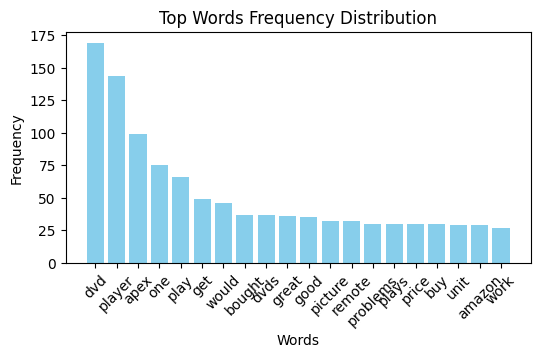

In [164]:

N = 20
top_items = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)[:N]
words, frequencies = zip(*top_items)
plt.figure(figsize=(6, 3))  
plt.bar(words, frequencies, color='skyblue')  
plt.xlabel('Words') 
plt.ylabel('Frequency') 
plt.title('Top Words Frequency Distribution')  # Title of the chart
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Display the plot
plt.show()